# Postprocessing of trained neural operators

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import torch

import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib
import matplotlib.pyplot as plt

def rescale(x):
    xnoN = x[~np.isnan(x)]
    return (x - np.min(xnoN)) / (np.max(xnoN) - np.min(xnoN))

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.titlepad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['font.size'] = 6
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.25
plt.rcParams['image.origin'] = 'upper'
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['savefig.format'] = 'svg'
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.transparent'] = True
plt.rcParams['savefig.pad_inches'] = 0.
plt.rcParams['savefig.dpi'] = 200

In [6]:
from train_Burgers import *
from pprint import pprint

# Four models achieve nearly identical performance with nearly identical kernels
# The first two were in tb_logs/long_run, the second two are tb_logs/validation_run
# Note that long_run models were trained for 500 epochs and then trained for 500 more as loss continued to improve
# We find a similar kernel for beta=1e-7 and beta=1e-8 which is smooth and slowly varying
# In the manuscript, we report the first model, which is in long_run and uses beta = 1e-7 (i.e. it is more "regularized")

beta=1e-7
info = torch.load('tb_logs/long_run/burgers_GFNN_b%.0e.ckpt' % beta, map_location='cpu')
model = GFNN(**info['hparams'])
pprint(info['hparams'])


model.load_state_dict(info['state_dict'])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval();

print(f"device = {device}")
print(f"{info['epoch']}, MSE={info['loss']:.3g}, Kernel={model.get_kernel_loss():.3g}")

{'base_lr': 0.0001,
 'batch_size': 32,
 'beta': 1e-07,
 'epochs': 500,
 'kernel_lr': 0.01,
 'pad': 25,
 'size': [50, 100]}
device = cuda:0
499, MSE=0.00181, Kernel=159


In [7]:
from train_Burgers import *

u = np.load('data/rescaled_1d.npy', mmap_mode='r')
print(u.shape)

tmin, xmin = 0, 0
frame_rate = 60 / 4
pixel_size = 18 / (u.shape[1]) #mm
tmax = 50 / frame_rate
xmax = 100 * pixel_size

t = np.linspace(0, model.kernel.shape[0] / frame_rate, model.kernel.shape[0])
x = np.linspace(0, model.kernel.shape[1] * pixel_size, model.kernel.shape[1])

T, X = np.meshgrid(t, x, indexing='ij')
    
t0 = model.kernel.shape[0] // 2
dx = model.kernel.shape[1] // 2
x0 = x.shape[0] // 2

with torch.no_grad():
    y0 = torch.FloatTensor(u)[:50, -100:].to(device)
    x0 = y0[None, 0:1, :]
    
    b, t, l = x0.shape
    pad_size = [t, l + model.pad]
    
    phi1 = model.read_in(x0)
        
    xq = torch.fft.fft2(phi1, s=pad_size)
    xq = xq * model.get_kernel()[None]
    phi1 = torch.fft.ifft2(xq).real[..., :-model.pad, :-model.pad]
    y1 = model.read_out(phi1.reshape([-1, 1, l])).reshape([b, -1, l])
    
    k = 3
    y1 = F.avg_pool2d(y1[None], (1, k), stride=1, padding=(0, k//2))[0]
    phi1 = F.avg_pool2d(phi1[None], (1, k), stride=1, padding=(0, k//2))[0]
        
    y0 = y0.cpu().numpy().squeeze()
    y1 = y1.cpu().numpy().squeeze()
    
    phi1 = phi1.cpu().numpy().squeeze()

#np.save('data/gfnn_y', y1)
#np.save('data/gfnn_phi', phi1)

(112, 200)


GFNN:	MAE=0.049, r-MAE=0.110
Near shock:	MAE=0.051, r-MAE=0.066
Mean field:	MAE=0.172, r-MAE=0.385
Mean field near shock:	MAE=0.337, r-MAE=0.430


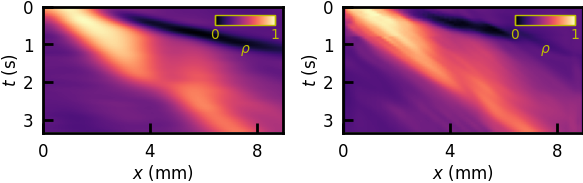

In [8]:
from sklearn.metrics import r2_score
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

kwargs = dict(extent=[xmin, xmax, tmax, tmin], vmin=0, vmax=1)

def plot_density_field(ax, rho, kwargs):
    #Note - video flows right to left, but we present things left to right
    im = ax.imshow(rho[:, ::-1], **kwargs)
    ax.set_aspect('auto')
    ax.set(xlabel='$x$ (mm)', xticks=[0, 4, 8],
           ylabel='$t$ (s)', yticks=[0, 1, 2, 3])
    cbax = inset_axes(ax, width=0.3, height=0.05, loc='upper right')
    cbar = plt.colorbar(im, cax=cbax, ticks=[0,1], orientation='horizontal')
    color='y'
    fontsize=plt.rcParams['font.size'] - 1
    cbar.ax.set_xlabel('$\\rho$', fontsize=fontsize, color=color, labelpad=0.5)
    cbar.ax.set_xticklabels([0, 1], fontsize=fontsize, color=color)
    cbar.outline.set_edgecolor(color)
    cbar.outline.set_linewidth(0.5)
    cbar.ax.xaxis.set_tick_params(color='y', width=0.5, pad=1)
    plt.setp(plt.getp(cbax, 'xticklabels'), color=color)

def MAE(input, target):
    return np.mean(np.abs(input - target))
def rMAE(input, target):
    return np.mean(np.abs(input - target)) / np.mean(np.abs(target))
    
fig, ax = plt.subplots(1, 2, figsize=(3, 1), dpi=200, constrained_layout=True)

print(f'GFNN:\tMAE={MAE(y1, y0):.3f}, r-MAE={rMAE(y1, y0):.3f}')
y_mean = np.mean(y0)

#Fit a line through the maxes of y0 in order to define a shock mask
xx = X[0, :-25]
tt = T[:-25, 0]

maxes = np.argmax(y0, axis=1)
max_X = xx[maxes]
fit = np.polyfit(tt, max_X, deg=1)
max_X = tt * fit[0] + fit[1]

diff = xx[None, :] - max_X[:, None]

mask = np.ones(y0.shape, dtype=bool)
mask[np.abs(diff) > .5] = 0
print(f'Near shock:\tMAE={MAE(y1[mask], y0[mask]):.3f}, r-MAE={rMAE(y1[mask], y0[mask]):.3f}')
print(f'Mean field:\tMAE={MAE(y_mean, y0):.3f}, r-MAE={rMAE(y_mean, y0):.3f}')
print(f'Mean field near shock:\tMAE={MAE(y_mean, y0[mask]):.3f}, r-MAE={rMAE(y_mean, y0[mask]):.3f}')
#print(f'R-MAE in the vicinity of the shock: {rMAE(y1[mask], y0[mask]):.3g}')

plot_density_field(ax[0], y0, kwargs)
plot_density_field(ax[1], y1, kwargs)
    
#fig.savefig(f'{savedir}/Burgers_comparison')

[0, 5, 15, 25, 35]
At t = 0 s, Peak at 0.727 mm
At t = 0.333 s, Peak at 1.64 mm
At t = 1 s, Peak at 2.55 mm
At t = 1.67 s, Peak at 3.45 mm
At t = 2.33 s, Peak at 5.27 mm


(2.3333333333333335, 0.0)

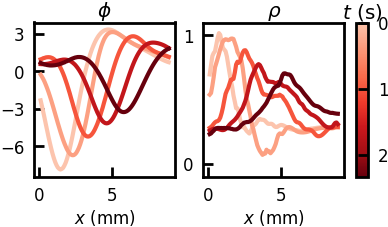

In [9]:
fig1, ax1 = plt.subplots(1, 2, figsize=(2, 1), dpi=200, 
                         sharex=True,
                         constrained_layout=False)

x = np.linspace(xmin, xmax, y1.shape[1])
ts = [0, 5, 15, 25, 35]
print(ts)

#Use a color offset to make the t = 0 visible
offset = 10
colors = [plt.cm.Reds((j+offset) / (ts[-1]+offset)) for j in ts]
for (t, color) in zip(ts, colors):
    ax1[0].plot(x[1:-1], phi1[t, ::-1][1:-1], c=color)
    ax1[1].plot(x[1:-1], y1[t, ::-1][1:-1], c=color)
    
    print(f'At t = {t / frame_rate:.3g} s, Peak at {x[np.argmax(y1[t, ::-1])]:.3g} mm')
    
'''
Formatting
'''
ax1[0].set_title('$\\phi$')
ax1[1].set_title('$\\rho$')
ax1[1].set(ylim=[-0.1, 1.1], yticks=[0, 1])

ax1[0].set(yticks=[-6, -3, 0, 3])
ax1[0].set(xlabel='$x$ (mm)')
ax1[1].set(xlabel='$x$ (mm)')


'''
Colorbars
'''
fig1.subplots_adjust(right=0.9)
norm = matplotlib.colors.Normalize(vmin=0, vmax=ts[-1] / frame_rate)
norm = matplotlib.colors.Normalize(vmin=-offset/frame_rate, vmax=ts[-1] / frame_rate)

y0 = ax1[1].get_position().y0
dy = ax1[1].get_position().y1 - y0
cax = fig1.add_axes([0.93, y0, 0.03, dy])
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='Reds', norm=norm),
                    cax=cax, ticks=[0, 1, 2])
cbar.ax.set_title('$t$ (s)')
ylim = cbar.ax.get_ylim()
cbar.ax.set_ylim([ylim[1], 0])
#cbar.ax.set_ylim(cbar.ax.get_ylim()[::-1])

#fig1.savefig(f'{savedir}/Burgers_variables')

(75, 121)


Text(0.5, 1.0, '$t$ (s)')

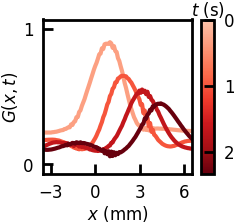

In [10]:
#Get kernel
with torch.no_grad():
    kernel = model.get_kernel()
    kernel = torch.fft.ifft2(kernel).real
    kernel = torch.fft.ifftshift(kernel, dim=-1)
    kernel = F.avg_pool2d(kernel[None], (1, 5), stride=1)[0]
    kernel = kernel.cpu().numpy()
    print(kernel.shape)
    kernels = rescale(kernel[:, ::-1]) #Remember x-axis is reversed in visualizing

k0 = kernel[0]
xi = np.arange(0, k0.shape[0]) - k0.shape[0] // 2
x_offset = xi[np.argmax(k0)] #Offset for traveling solutions
xi = (xi + x_offset).astype(float) * pixel_size

fig, ax = plt.subplots(1, 1, figsize=(1.2, 1), dpi=200, 
                         sharex=True, constrained_layout=False)

tmin, xmin = 0, 0
tmax = u.shape[0] / frame_rate
xmax = u.shape[1] * pixel_size

t = np.linspace(tmin, tmax, u.shape[0])
x = np.linspace(-xmax/2, xmax/2, u.shape[1])
T, X = np.meshgrid(t, x, indexing='ij')

offset = 10
dts = [5, 15, 25, 35]

colors = [plt.cm.Reds((j+offset) / (dts[-1]+offset)) for j in dts]
for dt, color in zip(dts, colors):    
    ki = kernels[dt]
    ax.plot(xi, ki, c=color)
    
'''
Formatting
'''
ax.set(yticks=[0, 1], ylim=[-0.07, 1.07], ylabel='$G(x, t)$')
ax.set(xticks=[-3, 0, 3, 6], xlim=[-3.5, 6.5], xlabel='$x$ (mm)')


'''
Colorbars
'''

fig.subplots_adjust(right=0.9)
norm = matplotlib.colors.Normalize(vmin=0, vmax=dts[-1] / frame_rate)
norm = matplotlib.colors.Normalize(vmin=-offset/frame_rate, vmax=dts[-1] / frame_rate)

cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='Reds', norm=norm), ax=ax, aspect=12, ticks=[2, 1, 0])
ylim = cbar.ax.get_ylim()
cbar.ax.set_ylim([ylim[1], 0])
cbar.ax.set_title('$t$ (s)', fontsize=plt.rcParams['axes.labelsize'])

#fig.savefig(f'{savedir}/Burgers_GF')

# Further investigation of GFNN solution

First, we examine the Green's function itself by collapsing it onto a master curve. Recall that the Burger's Green's function is 
\begin{equation}
    G(x, t) = \frac{1}{\sqrt{4\pi D t}} \exp \left[-\frac{(x - \mu u_0\  t)^2}{4 D t} \right] \Theta(t)
\end{equation}
That is, $G(x, t) = H(x - \mu u_0 \ t, t)$, where $H(x, t)$ is the standard heat kernel. We find that the GFNN solution can be collapsed by writing $G(x, t) = F(x - \mu u_0\ t + x_0, t)$

(75, 121)
-5.444999999999999 5.444999999999999 0.09074999999999989
-9.0 9.0 0.09045226130653283
-5.444999999999999 5.444999999999999 0.09074999999999989
-9.0 9.0 0.09045226130653283
-5.444999999999999 5.444999999999999 0.09074999999999989
-9.0 9.0 0.09045226130653283
-5.444999999999999 5.444999999999999 0.09074999999999989
-9.0 9.0 0.09045226130653283


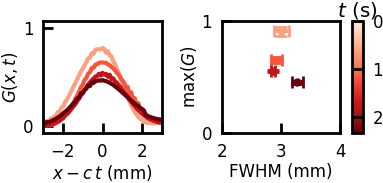

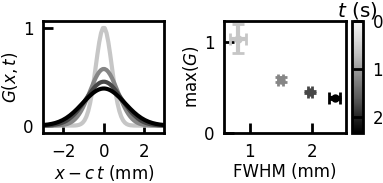

In [11]:
#Get kernel
with torch.no_grad():
    kernel = model.get_kernel()
    kernel = torch.fft.ifft2(kernel).real
    kernel = torch.fft.ifftshift(kernel, dim=-1)
    kernel = F.avg_pool2d(kernel[None], (1, 5), stride=1)[0]
    kernel = kernel.cpu().numpy()
    print(kernel.shape)
    kernels = rescale(kernel[:, ::-1]) #Remember x-axis is reversed in visualizing

def fwhm(f, dx=pixel_size):
    #f is f[T, X]
    fmax = np.max(f)
    half_max = fmax / 2
    above = np.argwhere(f >= half_max)
    
    left = above.min()
    right = above.max()
    return (right - left) * dx

xmax = u.shape[1] * pixel_size
tmax = u.shape[0] / frame_rate
xx = np.linspace(-xmax/2, xmax/2, u.shape[1])
tt = np.linspace(-tmax/2, tmax/2, u.shape[0])
    
xmax = kernel.shape[1] * pixel_size
tmax = kernel.shape[0] / frame_rate
x = np.linspace(-xmax/2, xmax/2, kernel.shape[1])
t = np.linspace(-tmax/2, tmax/2, kernel.shape[0])


A, B, D = 2.792, -1.592, 0.233
def exact(x, t):
    return np.exp(-(x - A * t)**2 / (4 * D * t)) / np.sqrt(4 * np.pi * D * t)

t0 = kernel.shape[0] // 2
dts = [5, 15, 25, 35]
escale = exact(x, dts[0] / frame_rate).max()

offset = 10
t_colors = [plt.cm.Reds((j+offset) / (dts[-1]+offset)) for j in dts]
e_colors = [plt.cm.Greys((j+offset) / (dts[-1]+offset)) for j in dts]

fig1, ax1 = plt.subplots(1, 2, figsize=(2, 1), dpi=200, constrained_layout=True)
fig2, ax2 = plt.subplots(1, 2, figsize=(2, 1), dpi=200, constrained_layout=True)

for i in range(len(dts)):
    ti = dts[i] / frame_rate
    ei = exact(xx + A * ti, ti) / escale
    ki = rescale(kernels[dts])[i]
    offset = x[np.argmax(ki)]
    xi = x - offset

    #Pad periodic (FFT) and interpolate to get full domain
    ki = np.concatenate([ki, ki])
    xii = np.concatenate([xi, xi+np.ptp(x) + (x[1]-x[0])])
    ax1[0].plot(xii, ki - ki.min(), c=t_colors[i])
    ax2[0].plot(xx, ei - ei.min(), c=e_colors[i])

    ki = kernels[dts[i]-2:dts[i]+3]
    t1 = np.linspace(-2, 2, 5) / frame_rate + ti
    print(x.min(), x.max(), x[1] - x[0])
    print(xx.min(), xx.max(), xx[1] - xx[0])
    ei = exact(xx[None, :], t1[:, None]) / escale
        
    fk = np.apply_along_axis(fwhm, 1, ki)
    fe = np.apply_along_axis(fwhm, 1, ei)
    
    mk = np.max(ki, axis=1)
    me = np.max(ei, axis=1)
    
    ax1[1].errorbar(fk.mean(), mk.mean(), 
                      yerr=mk.std(), xerr=fk.std(), 
                      linestyle='', color=t_colors[i], 
                      marker='o', markersize=2, capsize=2)
    ax2[1].errorbar(fe.mean(), me.mean(), 
                      yerr=me.std(), xerr=fe.std(), 
                      linestyle='', color=e_colors[i],
                      marker='o', markersize=2, capsize=2)

'''
Formatting
'''
for ax in (ax1, ax2):
    ax[0].set_ylabel('$G(x, t)$')
    ax[0].set(yticks=[0, 1], ylim=[-0.07, 1.07])
    ax[0].set(xticks=[-2, 0, 2], xlim=[-3, 3])
    ax[0].set(xlabel='$x - c\, t$ (mm)')
    ax[0].set(xticks=[-2, 0, 2], xlim=[-3, 3])
    ax[0].set(yticks=[0, 1], ylim=[-0.07, 1.07])
    
    ax[1].set_xlabel('FWHM (mm)')
    ax[1].set_ylabel('$\max(G)$')
    ax[1].set(yticks=[0, 1])
    ax[1].set(yticks=[0, 1])

    ax[0].set_aspect('auto')
    ax[1].set_aspect('auto')

ax1[1].set_xticks([2, 3, 4])
ax2[1].set_xticks([1, 2])

norm = matplotlib.colors.Normalize(vmin=0, vmax=dts[-1] / frame_rate)
norm = matplotlib.colors.Normalize(vmin=-offset/frame_rate, vmax=dts[-1] / frame_rate)
def add_colorbar(fig, ax, cmap='Reds'):
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax[1], ticks=[0,1,2], aspect=10)
    cbar.ax.set_title('$t$ (s)')
    #cbar.ax.set_ylim(cbar.ax.get_ylim()[::-1])
    ylim = cbar.ax.get_ylim()
    cbar.ax.set_ylim([ylim[1], 0])

add_colorbar(fig1, ax1, 'Reds')
add_colorbar(fig2, ax2, 'Greys')

#fig1.savefig(f'{savedir}/GFNN_FWHM')
#fig2.savefig(f'{savedir}/CH_FWHM')

## Can we learn anything about the machine-learned transformations?

(5000, 2) (5000, 1)


/home/jcolen/envs/default-pytorch-gpu-2.1.0/lib/python3.10/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 10000 iterations.
  warnings.warn(


u = -0.114 sin(1 u) u_x + 0.028 sin(1 u) u u_x^2 + 1.825 sin(1 u) u_x^3 + -0.465 cos(1 u) u_x^3 + -2388.356 sin(1 u_x) 1 + -0.700 sin(1 u_x) u u_x + 805.220 sin(1 u_x) u_x^2 + -0.346 sin(1 u_x) u u_x^2 + -37.405 sin(1 u_x) u_x^3 + 0.339 cos(1 u_x) 1 + 2388.327 cos(1 u_x) u_x + -0.052 cos(1 u_x) u u_x + 6.009 cos(1 u_x) u_x^2
Nonzero coefficeints:  14 / 40
Reverse-transformation R2 Score: 0.387
Experiment R2 Score: 0.411
Reverse-transformation MAE: 0.085
Experiment MAE: 0.100
Reverse-transformation relative MAE: 0.198


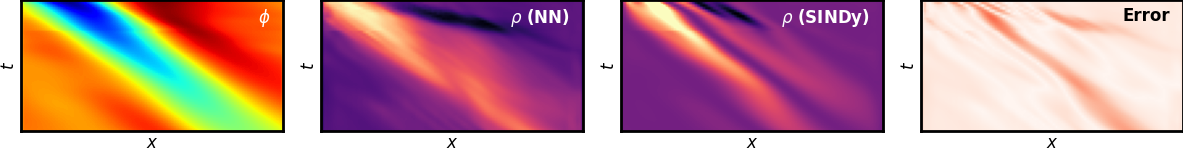

In [77]:
import pysindy as ps
from sklearn.metrics import r2_score
from scipy.ndimage import gaussian_filter

phi = phi1.copy()
sigma = (0, 3)
X = np.stack([
    gaussian_filter(phi, sigma=sigma).flatten(),
    gaussian_filter(phi, sigma=sigma, order=1).flatten(),
], axis=-1)
f0 = y1.flatten()[:, None]

print(X.shape, f0.shape)

fourier = ps.FourierLibrary(n_frequencies=1)
poly    = ps.PolynomialLibrary(degree=3)
library = fourier * poly

sindy = ps.SINDy(
    feature_library=library,
    optimizer=ps.SR3(
        threshold=5e1, nu=1e1,  #14 terms, r-MAE = 0.20
        thresholder='l1',
        max_iter=10000,normalize_columns=True),
    feature_names=['u', 'u_x'],
)

y0 = u[:50, -100:]

sindy.fit(X, x_dot=f0)
sindy.print(lhs=['u'])
print('Nonzero coefficeints: ', np.sum(sindy.coefficients() != 0), '/', sindy.coefficients().shape[1])
f1 = sindy.predict(X).reshape(y1.shape)    
print(f'Reverse-transformation R2 Score: {r2_score(y1, f1):.3g}') 
print(f'Experiment R2 Score: {r2_score(y0, f1):.3g}')
print(f'Reverse-transformation MAE: {np.mean(np.abs(y1 - f1)):.3f}')
print(f'Experiment MAE: {np.mean(np.abs(y0 - f1)):.3f}')
print(f'Reverse-transformation relative MAE: {np.mean(np.abs(y1 - f1)) / np.mean(y1):.3g}')

fig, ax = plt.subplots(1, 4, figsize=(6, 1), dpi=200, 
                       squeeze=False, constrained_layout=True)

#Note - video flows right to left, but we present things left to right
kwargs = dict(cmap='jet', extent=[xmin, xmax, tmax, tmin])
ax[0, 0].text(0.95, 0.95, '$\\phi$', 
              color='white', fontweight='bold',
              transform=ax[0, 0].transAxes,
              va='top', ha='right')
ax[0, 0].imshow(phi1[:, ::-1], **kwargs)

kwargs['vmin'] = 0
kwargs['vmax'] = 1
kwargs['cmap'] = 'magma'
ax[0, 1].text(0.95, 0.95, '$\\rho$ (NN)', 
              color='white', fontweight='bold',
              transform=ax[0, 1].transAxes,
              va='top', ha='right')
ax[0, 1].imshow(y1[:, ::-1], **kwargs)

ax[0, 2].text(0.95, 0.95, '$\\rho$ (SINDy)', 
              color='white', fontweight='bold',
              transform=ax[0, 2].transAxes,
              va='top', ha='right')
ax[0, 2].imshow(f1[:, ::-1], **kwargs)

kwargs['cmap'] = 'Reds'
ax[0, 3].text(0.95, 0.95, 'Error', 
              color='black', fontweight='bold',
              transform=ax[0, 3].transAxes,
              va='top', ha='right')
ax[0, 3].imshow(np.abs(y1-f1)[:, ::-1], **kwargs)

for a in ax.flatten():
    a.set_aspect(xmax / tmax / 2.)
    a.set(xlabel='$x$', xticks=[],
          ylabel='$t$', yticks=[])

plt.savefig('Figures/Burgers_phi2u.svg', bbox_inches='tight')

(5000, 2) (5000, 1)


/home/jcolen/envs/default-pytorch-gpu-2.1.0/lib/python3.10/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 10000 iterations.
  warnings.warn(


u = -34248.348 sin(1 u) u_x + 45904.141 sin(1 u) u^2 + 72609.812 sin(1 u) u_x^2 + 166986.062 sin(1 u) u u_x^2 + 1.785 cos(1 u) 1 + -11887.586 cos(1 u) u_x + 1942.722 cos(1 u) u^2 + 49203.445 cos(1 u) u_x^2 + -17120.441 cos(1 u) u^3 + 2024.883 cos(1 u) u^2 u_x + -111408.523 cos(1 u) u_x^3 + 11642.133 sin(1 u_x) 1 + 39869.012 sin(1 u_x) u + 13009.148 sin(1 u_x) u^2 + -84709.984 sin(1 u_x) u u_x + -117529.602 sin(1 u_x) u^2 u_x + 129281.969 sin(1 u_x) u u_x^2 + 232297.141 sin(1 u_x) u_x^3 + -1980.719 cos(1 u_x) u^2 + -3323.717 cos(1 u_x) u u_x + -48920.855 cos(1 u_x) u_x^2 + -28457.307 cos(1 u_x) u^3 + -27122.340 cos(1 u_x) u^2 u_x
Nonzero coefficeints:  23 / 40
Forward-transformation R2 Score: 0.702
Forward-transformation MAE: 0.696
Forward-transformation relative MAE: 0.378


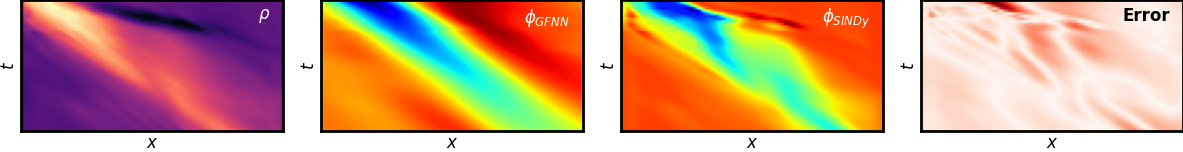

In [78]:
import pysindy as ps
from sklearn.metrics import r2_score
from scipy.ndimage import gaussian_filter

sigma = (0, 3)
X = np.stack([
    gaussian_filter(y1, sigma=sigma).flatten(),
    gaussian_filter(y1, sigma=sigma, order=1).flatten(),
], axis=-1)
f0 = phi1.flatten()[:, None]

print(X.shape, f0.shape)

fourier = ps.FourierLibrary(n_frequencies=1)
poly    = ps.PolynomialLibrary(degree=3)
library = fourier * poly

sindy = ps.SINDy(
    feature_library=library,
    optimizer=ps.SR3(threshold=1e3, nu=1e1, #23 terms, r-MAE = 0.38
                     thresholder='l1', 
                     max_iter=10000, normalize_columns=True),
    feature_names=['u', 'u_x'],
)

sindy.fit(X, x_dot=f0)
sindy.print(lhs=['u'])
print('Nonzero coefficeints: ', np.sum(sindy.coefficients() != 0), '/', sindy.coefficients().shape[1])
f1 = sindy.predict(X).reshape(y1.shape)    
print(f'Forward-transformation R2 Score: {r2_score(phi1, f1):.3g}') 
print(f'Forward-transformation MAE: {np.mean(np.abs(phi1 - f1)):.3g}')
print(f'Forward-transformation relative MAE: {np.mean(np.abs(phi1 - f1)) / np.mean(np.abs(phi1)):.3g}')
fig, ax = plt.subplots(1, 4, figsize=(6, 1), dpi=200, 
                       squeeze=False, constrained_layout=True)

#Note - video flows right to left, but we present things left to right
kwargs = dict(cmap='magma', extent=[xmin, xmax, tmax, tmin], vmin=0, vmax=1)
ax[0, 0].text(0.95, 0.95, '$\\rho$', 
              color='white', fontweight='bold',
              transform=ax[0, 0].transAxes,
              va='top', ha='right')
ax[0, 0].imshow(y1[:, ::-1], **kwargs)

kwargs['vmin'] = None
kwargs['vmax'] = None
kwargs['cmap'] = 'jet'
ax[0, 1].text(0.95, 0.95, '$\\phi_{GFNN}$', 
              color='white', fontweight='bold',
              transform=ax[0, 1].transAxes,
              va='top', ha='right')
ax[0, 1].imshow(phi1[:, ::-1], **kwargs)

ax[0, 2].text(0.95, 0.95, '$\\phi_{SINDy}$', 
              color='white', fontweight='bold',
              transform=ax[0, 2].transAxes,
              va='top', ha='right')
ax[0, 2].imshow(f1[:, ::-1], **kwargs)

kwargs['cmap'] = 'Reds'
ax[0, 3].text(0.95, 0.95, 'Error', 
              color='black', fontweight='bold',
              transform=ax[0, 3].transAxes,
              va='top', ha='right')
ax[0, 3].imshow(np.abs(phi1-f1)[:, ::-1], **kwargs)

for a in ax.flatten():
    a.set_aspect(xmax / tmax / 2.)
    a.set(xlabel='$x$', xticks=[],
          ylabel='$t$', yticks=[])


plt.savefig('Figures/Burgers_u2phi.svg', bbox_inches='tight')

## Can we use PDEFIND to uncover a differential equation for $\phi$?

The GFNN integrates a linear PDE so we should be able to discover a governing PDE for the integrated internal variable $\phi(x, t)$. 

In [81]:
import pysindy as ps
from sklearn.metrics import r2_score

phi = phi1.copy().T
xmax = phi.shape[0] * pixel_size
tmax = phi.shape[1] / frame_rate
x = np.linspace(xmin, xmax, phi.shape[0])
t = np.linspace(tmin, tmax, phi.shape[1])
dx = x[1] - x[0]
dt = t[1] - t[0]
phi = phi.reshape([x.shape[0], t.shape[0], 1])

# Define PDE library that is quadratic in phi, and
# third-order in spatial derivatives of phi.
library_functions = [lambda x: x]
library_function_names = [lambda x: x]
pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=5, spatial_grid=x,
                        include_interaction=False,
                        include_bias=False, 
                        is_uniform=True)

np.set_printoptions(precision=5)

print('With column normalization')
optimizer = ps.STLSQ(threshold=15, alpha=1e-2, normalize_columns=True)
sindy = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['phi'])
sindy.fit(phi, t=dt)
sindy.print()

library = sindy.feature_library.transform(phi)
library = library.reshape([-1, library.shape[-1]])
coefs = sindy.coefficients().squeeze()
print('Term strength (coefficient x L2 norm): ', coefs * np.linalg.norm(library, 2, axis=0))
print('Typical magnitude (coefficient x abs): ', coefs * np.mean(np.abs(library), axis=0))
#print('dx-Normalized coefficients: ', np.array([coefs[i] / dx**i for i in range(len(coefs))]))

print('----------------------')

print('Without column normalization')
optimizer = ps.STLSQ(threshold=1e-3, alpha=1e0, normalize_columns=False)
sindy = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['phi'])
sindy.fit(phi, t=dt)
sindy.print()

library = sindy.feature_library.transform(phi)
library = library.reshape([-1, library.shape[-1]])
coefs = sindy.coefficients().squeeze()
print('L2 Norms: ', np.linalg.norm(library, 2, axis=0))
print('Term strength (coefficient x L2 norm): ', coefs * np.linalg.norm(library, 2, axis=0))
print('Abs: ', np.mean(np.abs(library), axis=0))
print('Typical magnitude (coefficient x abs): ', coefs * np.mean(np.abs(library), axis=0))

With column normalization
(phi)' = -0.314 phi + 1.860 phi_1 + -0.012 phi_111
Term strength (coefficient x L2 norm):  [ -51.55585  290.00395    0.      -176.96729    0.        64.91194]
Typical magnitude (coefficient x abs):  [-0.57796  2.995    0.      -0.53848  0.       0.23528]
----------------------
Without column normalization
(phi)' = -0.311 phi + 1.861 phi_1 + 0.003 phi_11 + -0.008 phi_111
L2 Norms:  [1.64049e+02 1.55926e+02 9.97121e+02 1.42509e+04 2.03166e+05 2.81696e+06]
Term strength (coefficient x L2 norm):  [ -51.08391  290.1984     3.28248 -113.54558    0.         0.     ]
Abs:  [1.83906e+00 1.61032e+00 4.21027e+00 4.33630e+01 8.69534e+02 1.02102e+04]
Typical magnitude (coefficient x abs):  [-0.57267  2.99701  0.01386 -0.3455   0.       0.     ]


PDEFIND has found that the internal variable $\phi$ follows the equation
\begin{equation}
    \partial_t \phi - 1.86\, \partial_x \phi = -0.32\, \phi + 0.003\, \partial_x^2 \phi - 0.008\, \partial_x^3 \phi
\end{equation}

Finished integration:  (50, 100) (50,)
R2 Score for phi: 0.964
Relative-MAE Score for phi: 0.192
(50, 100)
R2 Score for rho: 0.73
MAE Score for rho: 0.0629
MAE Score for rho Experiments: 0.0719


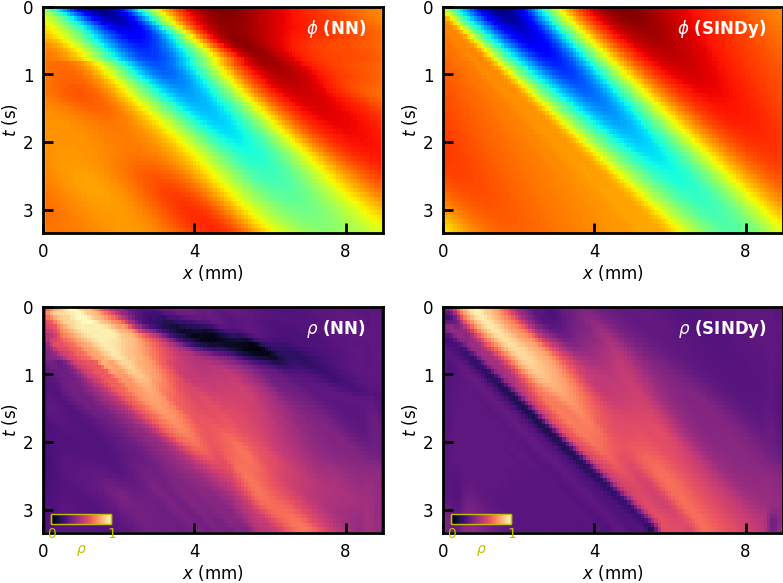

In [82]:
from scipy.ndimage import gaussian_filter

def rk4(u, func, dt):
    k1 = dt * func(u)
    k2 = dt * func(u + 0.5 * k1)
    k3 = dt * func(u + 0.5 * k2)
    k4 = dt * func(u + k3)
    return u + (k1 + 2 * k2 + 2 * k3 + k4) / 6

sigma = 1
mode='wrap'
def func(u):
    u_x = gaussian_filter(u, sigma, order=1, mode=mode) / dx
    u_xx = gaussian_filter(u, sigma, order=2, mode=mode) / dx**2
    u_xxx = gaussian_filter(u, sigma, order=3, mode=mode) / dx**3
    library = np.stack([
        u,
        u_x,
        u_xx,
        u_xxx,
    ], axis=1)
    return np.squeeze(library @ sindy.coefficients()[:, :-2].T)

i, ti = 0, tmin
phi_m = []
phi = phi1[0].copy()
while i < phi1.shape[0]:
    phi_m.append(phi.copy())
    phi = rk4(phi, func, dt)
    if np.any(np.isnan(phi)):
        print('Breaking early')
        break
    i += 1
    ti += dt
    
phi_m = np.stack(phi_m)
phi_m = gaussian_filter(phi_m, sigma=1) #Smooth to remove edge artifacts
t_m = np.linspace(0, ti, len(phi_m))
print('Finished integration: ', phi_m.shape, t_m.shape)

print(f'R2 Score for phi: {r2_score(phi1.flatten(), phi_m.flatten()):.3g}')
print(f'Relative-MAE Score for phi: {np.mean(np.abs(phi1 - phi_m)) / np.mean(np.abs(phi1)):.3g}')


with torch.no_grad():
    phi = torch.from_numpy(phi_m).float().to(device)
    y_m = model.read_out(phi[:, None]).squeeze()
    y_m = y_m.cpu().numpy()
    y_m = gaussian_filter(y_m, sigma=1)

print(y1.shape)
print(f'R2 Score for rho: {r2_score(y1.flatten(), y_m.flatten()):.3g}')
print(f'MAE Score for rho: {np.mean(np.abs(y1 - y_m)):.3g}')
print(f'MAE Score for rho Experiments: {np.mean(np.abs(y0 - y_m)):.3g}')


def plot_density_field(ax, rho, kwargs, colorbar=True):
    #Note - video flows right to left, but we present things left to right
    im = ax.imshow(rho[:, ::-1], **kwargs)
    ax.set_aspect('auto')
    ax.set(xlabel='$x$ (mm)', xticks=[0, 4, 8],
           ylabel='$t$ (s)', yticks=[0, 1, 2, 3])
    
    if colorbar:
        cbax = inset_axes(ax, width=0.3, height=0.05, loc='lower left')
        cbar = plt.colorbar(im, cax=cbax, ticks=[0,1], orientation='horizontal')
        color='y'
        fontsize=plt.rcParams['font.size'] - 1
        cbar.ax.set_xlabel('$\\rho$', fontsize=fontsize, color=color, labelpad=0.5)
        cbar.ax.set_xticklabels([0, 1], fontsize=fontsize, color=color)
        cbar.outline.set_edgecolor(color)
        cbar.outline.set_linewidth(0.5)
        cbar.ax.xaxis.set_tick_params(color='y', width=0.5, pad=1)
        plt.setp(plt.getp(cbax, 'xticklabels'), color=color)

#Note - video flows right to left, but we present things left to right
fig, ax = plt.subplots(2, 2, figsize=(4, 3), dpi=200, 
                       constrained_layout=True)

kwargs = dict(extent=[xmin, xmax, tmax, tmin], cmap='jet')

plot_density_field(ax[0, 0], phi1, kwargs, colorbar=False)
plot_density_field(ax[0, 1], phi_m, kwargs, colorbar=False)

fig.text(0.95, 0.95, '$\\phi$ (NN)', 
         color='white', fontweight='bold',
         transform=ax[0, 0].transAxes,
         va='top', ha='right')
fig.text(0.95, 0.95, '$\\phi$ (SINDy)', 
         color='white', fontweight='bold',
         transform=ax[0, 1].transAxes,
         va='top', ha='right')


kwargs = dict(extent=[xmin, xmax, tmax, tmin], vmin=0, vmax=1)

plot_density_field(ax[1, 0], y1, kwargs)
plot_density_field(ax[1, 1], y_m, kwargs)

fig.text(0.95, 0.95, '$\\rho$ (NN)', 
         color='white', fontweight='bold',
         transform=ax[1, 0].transAxes,
         va='top', ha='right')
fig.text(0.95, 0.95, '$\\rho$ (SINDy)', 
         color='white', fontweight='bold',
         transform=ax[1, 1].transAxes,
         va='top', ha='right')

plt.savefig('Figures/Burgers_internal.svg', bbox_inches='tight')